In [1]:
import pandas as pd
import numpy as np
import math
import operator
import os
import seaborn as sns

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from keybert._mmr import mmr
from keybert._maxsum import max_sum_distance
from keybert._highlight import highlight_document
from keybert.backend._utils import select_backend
from tqdm import tqdm
from typing import List, Union, Tuple
from matplotlib import pyplot as plt
from scipy import linalg
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

/home/slava/UNSW/translationanalysis-Georgianlanguage/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-07-23 20:30:58.166935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 20:30:58.176209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 20:30:58.187377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin 

In [3]:
model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
pd.options.display.max_colwidth = 250
texts_path = '../Georgian Texts/Vazha Pshavela/'
prose_path = texts_path + 'Prose/revised/'

In [5]:
prose_names = []
sources = ['ge/', 'en/', 'ggl/', 'gem/', 'gpt/']
ge_prose_directory = os.fsencode(prose_path + 'ge/')
for file in sorted(os.listdir(ge_prose_directory)):
    prose_names.append(file.decode())

In [6]:
print('Number of verses')
print('==============================================================================================')
print('ID\tVazha\tHewitt\tGoogle\tGemini\tGem_ru\tChatGPT\tGPT_ru\tPassed?\tProse Name')
for prose in prose_names:
    output = [prose[:2]]
    for source in sources:
        with open(prose_path + source + prose, "r") as file:
            output.append(str(sum(1 for _ in file)))
    if len(set(output[1:])) > 1:
        output.append('No')
    else:
        output.append('Yes')
    output.append(prose[3:-3].replace('_', ' ').title())
    print('\t'.join(output))

Number of verses
ID	Vazha	Hewitt	Google	Gemini	Gem_ru	ChatGPT	GPT_ru	Passed?	Prose Name
21	37	37	37	37	37	Yes	Violet
22	63	63	63	63	63	Yes	The Withered Beech
23	64	64	64	64	64	Yes	The Weeping Rock
24	61	61	61	61	61	Yes	The Lofty Mountains
25	105	105	105	105	105	Yes	The Vulture
26	51	51	51	51	51	Yes	The Forest Was Crying
27	92	92	92	92	92	Yes	The Coarse Grass
28	49	49	49	49	49	Yes	The Mountain Spring
29	44	44	44	44	44	Yes	Roots
30	86	86	86	86	86	Yes	Its Rising Its Getting Light
31	110	110	110	110	110	Yes	A Small Shepherds Thoughts
32	159	159	159	159	159	Yes	The Wedding Of The Jays


In [7]:
verses = []
prose_verse_counts = []
df = pd.DataFrame(
    columns=[
        'Prose ID',
        'Prose Name',
        'Verse',
        'Vazha',
        'Hewitt',
        'Google',
        'Gemini',
        'ChatGPT',
        'Hewitt - Google',
        'Hewitt - Gemini',
        'Hewitt - ChatGPT',
    ]
)

for prose in prose_names:
    prose_id = int(prose[:2])
    prose_name = prose[3:-3].replace('_', ' ').title()

    prose_vazha = [line.strip() for line in open(prose_path + 'ge/' + prose, "r")]
    prose_hewitt = [line.strip() for line in open(prose_path + 'en/' + prose, "r")]
    prose_google = [line.strip() for line in open(prose_path + 'ggl/' + prose, "r")]
    prose_gemini = [line.strip() for line in open(prose_path + 'gem/' + prose, "r")]
    prose_chatgpt = [line.strip() for line in open(prose_path + 'gpt/' + prose, "r")]

    verses.extend(prose_hewitt)
    verses.extend(prose_google)
    verses.extend(prose_gemini)
    verses.extend(prose_chatgpt)

    prose_verse_counts.append(len(prose_vazha))
    for i in range(len(prose_vazha)):
        row = {
            'Prose ID': [prose_id],
            'Prose Name': [prose_name],
            'Verse': [i + 1],
            'Vazha': [prose_vazha[i]],
            'Hewitt': [prose_hewitt[i]],
            'Google': [prose_google[i]],
            'Gemini': [prose_gemini[i]],
            'ChatGPT': [prose_chatgpt[i]]
        }
        df_new = pd.DataFrame(row)
        df = pd.concat([df, df_new], ignore_index = True)

df.shape

(921, 11)

In [8]:
df.to_csv('results/prose/all_texts.csv')

In [9]:
verse_embeddings = model.encode(verses)
verse_embeddings.shape

(3684, 768)

In [10]:
prose_verse_counts

[37, 63, 64, 61, 105, 51, 92, 49, 44, 86, 110, 159]

In [11]:
for i, row in df.iterrows():
    prose_id = row['Prose ID'] - 20
    verse = row['Verse']
    offset = sum(prose_verse_counts[:prose_id-1]) * 4
    j = offset + verse - 1

    hewitt_google = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 1 * prose_verse_counts[prose_id - 1]]]
    )[0][0]
    
    hewitt_gemini = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 2 * prose_verse_counts[prose_id - 1]]]
    )[0][0]

    hewitt_chatgpt = cosine_similarity(
        [verse_embeddings[j]],
        [verse_embeddings[j + 3 * prose_verse_counts[prose_id - 1]]]
    )[0][0]

    df.at[i,'Hewitt - Google'] = hewitt_google
    df.at[i,'Hewitt - Gemini'] = hewitt_gemini
    df.at[i,'Hewitt - ChatGPT'] = hewitt_chatgpt

In [12]:
df.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT
0,21,Violet,1,უღრანს ტყეში მოსული ვარ…,I have sprung to life in a dense forest…,I have come to the dense forest...,I have come to a dense forest...,I have come to the dense forest...,0.802988,0.827873,0.802988
1,21,Violet,2,"მანამ ცოცხალი ვარ, ჩემის სილამაზით დავატკბობ ტყეს, ბალახს და იმ გაღმიდამ გამომცქერალს გულხავსიანს კლდესა, სუნელებას მივაფრქვევ არე-მარეს.","While I live, with my beauty I shall bring sweetness to the forest, the grass and that rock which gazes over from across the river, with its bosom clothed in moss; I shall spread my delightful aroma all around.","As long as I am alive, I will sweeten the forest, the grass, and the mossy rock with my beauty, I will sprinkle spices on the surroundings.","As long as I am alive, I will delight the forest, the grass, and that heart-shaped rock looking at me from afar with my beauty, I will spread fragrance around.","As long as I am alive, I will grace the forest, the grass, and that rough cliff watching from afar with my beauty. I will spread my fragrance to the surroundings.",0.831107,0.876884,0.846976
2,21,Violet,3,"ყველას ვუყვარვარ: აგერ იმ დამპალს ყუნჭს თვალი სულ ჩემსკენ უჭირავს, მიცინის ხოლმე, უნდა ჩემთან მოვიდეს, – მაკოცოს, მაგრამ არ შეუძლიან, მხოლოდ შორიდამ გამიცინებს, გაიღიმება საცოდავი, თუმცა უშნოდ, მაგრამ გულკეთილობა კი დიდი გადაეფინება ხოლმე პირზედ.","I am loved by all; just here that rotting tree-stump has its eye constantly fixed on me; it laughs in my direction and wants to come over — to kiss me, but it can’t; only from a distance will it continue to laugh and smile at me, poor thing; it m...","Everyone loves me: if that rotten bastard keeps his eyes on me, he laughs at me, he wants to come to me, - kiss me, but he can't, he only laughs at me from afar, he smiles pitifully, although ugly, but the kindness is sometimes reflected on his f...","Everyone loves me: that rotten stump over there has its eyes fixed on me, it smiles at me sometimes, it wants to come to me - to kiss me, but it can't, it just smiles at me from afar, the poor thing will smile, even though it's ugly, but great ki...","Everyone loves me: look at that rotting stump, its eyes always fixed on me, it smiles sometimes, wanting to come closer, to kiss me, but it cannot; it only smiles at me from a distance, poor thing, though unattractive, a great kindness spreads ov...",0.67326,0.854383,0.889966
3,21,Violet,4,განა მარტო იმას უხარიან ჩემი სიცოცხლე?,And do you think it’s only that stump which rejoices in my existence?,Is that the only reason they enjoy my life?,Is it only him who is happy with my life?,Is it only that which rejoices in my life?,0.301155,0.290536,0.521672
4,21,Violet,5,"წვერხმელი ხეებიც მე დამხარიან ზევიდამ, თვითონ თავშიშველნი, ტოტებს მე მაფარებენ: ჩვენს იას არ შეგვიცივდეს, ან არაფერმა არ აწყინოსო.","The trees too with their dry, beard-like foliage joyfully look down on me from above — themselves bare-headed, they cover me with their branches: “Our little violet mustn’t catch cold; nothing must upset her,” they say.","Even the topless trees are leaning on me from above, they themselves are bare, their branches cover me: let not our yew get cold, or let nothing freeze.","The bearded trees also lean towards me from above, themselves bareheaded, they cover me with their branches: Let our violet not catch a cold, or let nothing hurt it.","Even the dead trees support me from above, themselves bare-headed, they cover me with their branches: ""Let our violet not get cold, or be harmed by anything.""",0.765149,0.871555,0.825085


In [13]:
df.to_csv('results/prose/similarity/cosine_similarity.csv')

In [14]:

# maximum_difference_easwaran_gandhi.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/easwaran gandhi.csv')
# maximum_difference_gandhi_purohit.to_csv('/content/drive/MyDrive/religious_texts/semantic analysis/all-mpnet-base-v2/gandhi purohit.csv')
# maximum_difference_purohit_easwaran.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/purohit_google.csv')
# df.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine similarity - sklearn.csv')
# df_max_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/max_sum_in_every_chapter.csv')
# df_min_sum_cs.to_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/least_sum_in_every_chapter.csv')
# df = pd.read_csv('/content/drive/MyDrive/github/sentimentanalysis_bhagavadgita-main/SM_RESULTS/cosine_similarity.csv')

In [15]:
maximum_difference_hewitt_google = df.loc[(df['Hewitt - Google'] < 0.5)]
maximum_difference_hewitt_google.shape

(177, 11)

In [16]:
maximum_difference_hewitt_gemini = df.loc[(df['Hewitt - Gemini'] < 0.5)]
maximum_difference_hewitt_gemini.shape

(53, 11)

In [17]:
maximum_difference_hewitt_chatgpt = df.loc[(df['Hewitt - ChatGPT'] < 0.5)]
maximum_difference_hewitt_chatgpt.shape

(57, 11)

In [18]:
maximum_difference = df.loc[(df['Hewitt - Google']<0.5) & (df['Hewitt - Gemini'] < 0.5) & (df['Hewitt - ChatGPT'] < 0.5)]
maximum_difference.shape

(22, 11)

In [19]:
df['Sum CS'] = df['Hewitt - Google'] + df['Hewitt - Gemini'] + df['Hewitt - ChatGPT']
df['Max Sum CS'] = df.groupby(['Prose Name'])['Sum CS'].transform('max')
df['Min Sum CS'] = df.groupby(['Prose Name'])['Sum CS'].transform('min')

In [20]:
df_max_sum_cs = df.loc[(df['Max Sum CS'] == df['Sum CS'])]
df_max_sum_cs.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT,Sum CS,Max Sum CS,Min Sum CS
18,21,Violet,19,"რასაც კი დაინახავს, უნდა რომ თავის სასარგებლოდ მოიხმაროს.","Whatever he sees, he wants to use for his own advantage.","Whatever he sees, he wants to use it for his own benefit.","Whatever he sees, he wants to use it for his own benefit.","Whatever he sees, he wants to use for his own benefit.",0.953822,0.953822,0.955635,2.863278,2.863278,1.113363
68,22,The Withered Beech,32,"მოსტყდება, წაიქცევა, გვერდზე წაწვება, ფესვები გამოჩნდებიან, აღმა თავაჭერილები, თითქოს ლოცულობდენ, ღმერთს ევედრებოდენ, შველასა სთხოვდენო.","It will crack, come crashing down, lie on its side; its roots will be exposed, raised up towards heaven, as though praying and beseeching God, appealing for help.","It will break, fall, be burned to the side, roots will appear, holding their heads up, as if they are praying, begging God for help.","It will fall, fall, lie on its side, the roots will appear, raised up, as if they were praying, begging God, asking for help.","It will break, fall, lie down on its side, its roots will be exposed, pointing upwards as if praying, pleading to God for help.",0.899311,0.89927,0.942607,2.741189,2.741189,1.279202
148,23,The Weeping Rock,49,არავინ.,No-one.,no one,No one.,No one.,0.928647,0.953851,0.953851,2.836348,2.836348,0.985496
181,24,The Lofty Mountains,18,"რატომ არ მღერით, მთებო?!","Mountains, why do you not sing?!","Why don't you sing, mountains?!","Why don't you sing, mountains?!","Why don't you sing, mountains?!",0.939933,0.939933,0.939933,2.8198,2.8198,1.252839
225,25,The Vulture,1,ზაფხული იყო.,It was summer.,It was summer.,It was summer.,It was summer.,1.0,1.0,1.0,3.0,3.0,0.62748


In [21]:
df_min_sum_cs = df.loc[(df['Min Sum CS'] == df['Sum CS'])]
df_min_sum_cs.head()

,Prose ID,Prose Name,Verse,Vazha,Hewitt,Google,Gemini,ChatGPT,Hewitt - Google,Hewitt - Gemini,Hewitt - ChatGPT,Sum CS,Max Sum CS,Min Sum CS
3,21,Violet,4,განა მარტო იმას უხარიან ჩემი სიცოცხლე?,And do you think it’s only that stump which rejoices in my existence?,Is that the only reason they enjoy my life?,Is it only him who is happy with my life?,Is it only that which rejoices in my life?,0.301155,0.290536,0.521672,1.113363,2.863278,1.113363
88,22,The Withered Beech,52,ვაჰ.,Alas!,oh how hard it is to die,"Oh,",Alas,0.219803,0.201828,0.85757,1.279202,2.741189,1.279202
149,23,The Weeping Rock,50,ერთი მარტო გოშიაა იმისი პატრონი.,Only one small dog attends to him.,There is only one Goshi who owns it,Only one marten is his master,Only his loyal dog,0.23864,0.231128,0.515727,0.985496,2.836348,0.985496
219,24,The Lofty Mountains,56,"რაღაცას. დიაღ, რაღაცას.","For something, surely, for something.","or what something Yes, something.","Something. Yes, something.","Something. Yes, something.",0.366156,0.443341,0.443341,1.252839,2.8198,1.252839
298,25,The Vulture,74,შენ ამოიყარე იმისი ჯავრი.,Get your own back on her.,You threw that shit out.,You can vent your anger there.,You take out your anger on it.,0.128139,0.185492,0.313848,0.62748,3.0,0.62748


In [22]:
print('Relation\tmean\t\t\tstd')
print(f"Hewitt-Google\t{df['Hewitt - Google'].mean()}\t{df['Hewitt - Google'].std()}")
print(f"Hewitt-Gemini\t{df['Hewitt - Gemini'].mean()}\t{df['Hewitt - Gemini'].std()}")
print(f"Hewitt-ChatGPT\t{df['Hewitt - ChatGPT'].mean()}\t{df['Hewitt - ChatGPT'].std()}")

Relation	mean			std
Hewitt-Google	0.6611900702361564	0.17895761152278614
Hewitt-Gemini	0.7479646332748032	0.14223487724280037
Hewitt-ChatGPT	0.7468576503757804	0.14667355212995428


In [23]:
df_mean_hewitt_google = df.groupby('Prose Name')['Hewitt - Google'].mean().reset_index()
df_mean_hewitt_gemini = df.groupby('Prose Name')['Hewitt - Gemini'].mean().reset_index()
df_mean_hewitt_chatgpt = df.groupby('Prose Name')['Hewitt - ChatGPT'].mean().reset_index()

df_std_hewitt_google = df.groupby('Prose Name')['Hewitt - Google'].std().reset_index()
df_std_hewitt_gemini = df.groupby('Prose Name')['Hewitt - Gemini'].std().reset_index()
df_std_hewitt_chatgpt = df.groupby('Prose Name')['Hewitt - ChatGPT'].std().reset_index()

In [24]:
df_std_hewitt_google

,Prose Name,Hewitt - Google
0,A Small Shepherds Thoughts,0.157801
1,Its Rising Its Getting Light,0.195841
2,Roots,0.165629
3,The Coarse Grass,0.168286
4,The Forest Was Crying,0.164721
5,The Lofty Mountains,0.176414
6,The Mountain Spring,0.190004
7,The Vulture,0.199443
8,The Wedding Of The Jays,0.181485
9,The Weeping Rock,0.162593


In [25]:
df_std_hewitt_gemini

,Prose Name,Hewitt - Gemini
0,A Small Shepherds Thoughts,0.125957
1,Its Rising Its Getting Light,0.162366
2,Roots,0.123362
3,The Coarse Grass,0.152776
4,The Forest Was Crying,0.129674
5,The Lofty Mountains,0.144692
6,The Mountain Spring,0.141927
7,The Vulture,0.152760
8,The Wedding Of The Jays,0.139101
9,The Weeping Rock,0.126987


In [26]:
df_std_hewitt_chatgpt

,Prose Name,Hewitt - ChatGPT
0,A Small Shepherds Thoughts,0.146726
1,Its Rising Its Getting Light,0.151373
2,Roots,0.161075
3,The Coarse Grass,0.145855
4,The Forest Was Crying,0.129770
5,The Lofty Mountains,0.152444
6,The Mountain Spring,0.170352
7,The Vulture,0.152126
8,The Wedding Of The Jays,0.141888
9,The Weeping Rock,0.140379


In [27]:
df_mean_hewitt_google

,Prose Name,Hewitt - Google
0,A Small Shepherds Thoughts,0.639245
1,Its Rising Its Getting Light,0.643778
2,Roots,0.726362
3,The Coarse Grass,0.658403
4,The Forest Was Crying,0.726725
5,The Lofty Mountains,0.685587
6,The Mountain Spring,0.676432
7,The Vulture,0.639017
8,The Wedding Of The Jays,0.651476
9,The Weeping Rock,0.63351


In [28]:
df_mean_hewitt_gemini

,Prose Name,Hewitt - Gemini
0,A Small Shepherds Thoughts,0.728837
1,Its Rising Its Getting Light,0.755
2,Roots,0.792025
3,The Coarse Grass,0.729943
4,The Forest Was Crying,0.80801
5,The Lofty Mountains,0.74642
6,The Mountain Spring,0.775128
7,The Vulture,0.742353
8,The Wedding Of The Jays,0.743572
9,The Weeping Rock,0.726601


In [29]:
df_mean_hewitt_chatgpt

,Prose Name,Hewitt - ChatGPT
0,A Small Shepherds Thoughts,0.699298
1,Its Rising Its Getting Light,0.747184
2,Roots,0.772886
3,The Coarse Grass,0.743832
4,The Forest Was Crying,0.785461
5,The Lofty Mountains,0.746578
6,The Mountain Spring,0.759383
7,The Vulture,0.744649
8,The Wedding Of The Jays,0.738023
9,The Weeping Rock,0.727402


In [30]:
print('Google', df_std_hewitt_google['Hewitt - Google'].mean())
print('Gemini', df_std_hewitt_gemini['Hewitt - Gemini'].mean())
print('ChatGPT', df_std_hewitt_chatgpt['Hewitt - ChatGPT'].mean())

Google 0.1768639565595469
Gemini 0.13993604619118852
ChatGPT 0.14459100053862586


In [31]:
kw_model = KeyBERT(model = 'all-mpnet-base-v2')

In [32]:
####### METHODOLOGY FOR OBTAINING KEYWORDS

# We encode verses using the MPNet-base model to compute the verse by verse semantic similarity. 
# We use the MPNet-base model for extraction of keywords (using KeyBERT) from all chapters. 
# However, given the constraint in the MPNet-base model that number of tokens should not exceed 384, it would not be possible to encode large chapters directly. 
# Hence, we propose a method to overcome this limitation by breaking each chapter into paragraphs of 15 verses. 
# We include 3 verses from the previous paragraph into the current paragraph to retain some context and maintain continuity. 
# For example, in the first paragraph, verses 1-15 are included, and in the second paragraph verses 13-27, then 25-39, and so on.  
# We keep the top 20 keywords because keywords that have a lower similarity score in the original paragraph may be more relevant when the entire paragraph is considered.
 
# Next, we extract the keywords for all paragraphs i with 20 candidate keywords of paragraph j such that i!=j. 
# For each keyword, we add up its cosine similarity score across paragraphs. 
# Finally, we obtain the top 10 keywords having the highest cumulative scores. 
# The key idea here is that if a term is a keyword in a certain paragraph, it also needs to be sufficiently close to other paragraphs in the higher dimensional vector space
# to qualify as a keyword for the entire chapter. 
# We use MMR with a diversity value of 0.5 to prevent the selection of similar meaning keywords.

In [33]:
top_n = 20
final_df = pd.DataFrame()

for prose in prose_names:
    df = pd.read_csv('results/prose/sentiment/' + 'en/' + prose)
    df = df.drop(['Unnamed: 0', 'Official report'], axis=1)

    score_list = []
    text_list = []
    string_list = []
    keyword_score_map = {}
    keyword_count_map = {}

    for i in range(math.ceil(df.shape[0] / 15)):
        if i == 0:
            text = ' '.join(df[0:15].Tweet)
        else:
            if df.shape[0] >= 15 * (i + 1) - 3:
                text = ' '.join(df[(15 * i - 3):(15 * (i + 1) - 3)].Tweet)
            else:
                text = ' '.join(df[(15 * i - 3):df.shape[0]].Tweet)

        list1 = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=top_n, use_mmr=True, diversity=0.5)
        score_list.append(list1)
        text_list.append(text)

        for jj in range(0, top_n):
            keyword = score_list[0][jj][0]
            string_list.append(keyword)
            keyword_score_map[keyword] = 0
            keyword_count_map[keyword] = 0

    for ii in range(math.ceil(df.shape[0] / 15)):
        for jj in range(math.ceil(df.shape[0] / 15)):
            list2 = kw_model.extract_keywords(
               text_list[jj], 
               candidates=string_list[top_n * ii:top_n * (ii + 1)], 
               keyphrase_ngram_range=(1, 1), 
               stop_words='english', 
               top_n=top_n,
               use_mmr=True,
               diversity=0.3
            )
            for kk in range(0, len(list2)):
                keyword = list2[kk][0]
                keyword_score = list2[kk][1]
                keyword_score_map[keyword] += keyword_score
                keyword_count_map[keyword] += 1


    keyword_score_map = dict( sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))     # sort in descending order according to scores
    keyword_df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])                         # convert dictionary to dataframe
    keyword_df = keyword_df[:10]                                                                               # TOP 10 KEYWORDS most relevant to text 
    keyword_df['Prose'] = prose[3:-3].replace('_', ' ').title()
    keyword_df['Author'] = 'Hewitt'

    final_df = pd.concat([final_df, keyword_df], axis=0)

final_df

,Keyword,Score,Prose,Author
0,trees,1.3944,Violet,Hewitt
1,father,1.2900,Violet,Hewitt
2,leaflessness,1.1346,Violet,Hewitt
3,stump,1.0941,Violet,Hewitt
4,plumage,1.0125,Violet,Hewitt
...,...,...,...,...
5,jay,6.5780,The Wedding Of The Jays,Hewitt
6,exclaimed,6.5153,The Wedding Of The Jays,Hewitt
7,strewn,5.8531,The Wedding Of The Jays,Hewitt
8,guests,5.1425,The Wedding Of The Jays,Hewitt


In [34]:
final_df.to_csv('results/prose/keywords/hewitt_keywords.csv')

In [35]:
df = pd.read_csv('results/prose/keywords/hewitt_keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)

onlykey = df.loc[(df['Author'] == 'Hewitt')]
onlykey=onlykey['Keyword']
onlykey

1            father
2      leaflessness
3             stump
4           plumage
5            praise
           ...     
115             jay
116       exclaimed
117          strewn
118          guests
119        thousand
Name: Keyword, Length: 110, dtype: object

In [36]:
onlykey.to_csv('results/prose/keywords/hewitt_onlykey.tsv', sep='\t', index=None, header=None)

In [37]:
keyword_score_map = dict(sorted(keyword_score_map.items(), key=operator.itemgetter(1), reverse=True))

In [38]:
df = pd.DataFrame(keyword_score_map.items(), columns=['Keyword', 'Score'])
df.head()

,Keyword,Score
0,birds,40.3623
1,bride,17.2348
2,feast,16.1106
3,worm,7.3216
4,seeds,6.9685


In [39]:
model = KeyBERT(model='all-mpnet-base-v2')
model

In [40]:
df = pd.read_csv('results/prose/keywords/hewitt_keywords.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(subset='Keyword', keep='last', inplace=True)
df

,Keyword,Score,Prose,Author
1,father,1.2900,Violet,Hewitt
2,leaflessness,1.1346,Violet,Hewitt
3,stump,1.0941,Violet,Hewitt
4,plumage,1.0125,Violet,Hewitt
5,praise,0.9258,Violet,Hewitt
...,...,...,...,...
115,jay,6.5780,The Wedding Of The Jays,Hewitt
116,exclaimed,6.5153,The Wedding Of The Jays,Hewitt
117,strewn,5.8531,The Wedding Of The Jays,Hewitt
118,guests,5.1425,The Wedding Of The Jays,Hewitt


In [41]:
candidates = df['Keyword'].tolist()
candidates

['father',
 'leaflessness',
 'stump',
 'plumage',
 'praise',
 'aroma',
 'delightful',
 'heartedness',
 'river',
 'trees',
 'consolation',
 'tale',
 'relates',
 'mere',
 'wedding',
 'stand',
 'nature',
 'valley',
 'merit',
 'merely',
 'repose',
 'does',
 'foes',
 'legion',
 'expectancy',
 'mountains',
 'deity',
 'countenance',
 'await',
 'standing',
 'quivering',
 'journeyed',
 'dry',
 'unseen',
 'vultures',
 'carrion',
 'perched',
 'praises',
 'pestilence',
 'carcasses',
 'ravines',
 'pile',
 'look',
 'deer',
 'cawed',
 'kebab',
 'tastes',
 'better',
 'hullaballoo',
 'chap',
 'capering',
 'whimsically',
 'mountain',
 'grass',
 'weeps',
 'fall',
 'affliction',
 'causing',
 'plant',
 'chasm',
 'god',
 'spring',
 'flow',
 'boulders',
 'faced',
 'sin',
 'spit',
 'gazing',
 've',
 'evil',
 'earth',
 'oak',
 'withered',
 'snakes',
 'roots',
 'nourishment',
 'seasons',
 'onward',
 'afraid',
 'day',
 'ravenous',
 'forest',
 'snow',
 'night',
 'howling',
 'heard',
 'stillness',
 'week',
 'comra

In [42]:
doc,candidate_embeddings = model.extract_embeddings(candidates)

print(len(candidate_embeddings))
print(len(candidate_embeddings[0]))

110
768


In [43]:
candidate_embeddings

array([[-0.00739433,  0.01515381,  0.00267148, ...,  0.01550641,
        -0.03200549,  0.00100583],
       [ 0.0486432 , -0.04774459, -0.02491382, ...,  0.04280979,
        -0.00591392,  0.0218765 ],
       [ 0.00574163,  0.06250819, -0.03860545, ...,  0.02226792,
        -0.02366643, -0.00863477],
       ...,
       [ 0.01131211,  0.00649861,  0.00659491, ..., -0.03042342,
        -0.01524963, -0.0107492 ],
       [ 0.0165902 ,  0.01396419, -0.00024455, ...,  0.00103437,
        -0.02019885, -0.0250313 ],
       [-0.0098954 ,  0.04799373, -0.00419572, ..., -0.00987319,
        -0.03282537,  0.01588462]], dtype=float32)

In [44]:
candidate_embeddings = pd.DataFrame(candidate_embeddings)
candidate_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.007394,0.015154,0.002671,-0.019277,-0.015509,0.031646,-0.043719,0.016654,-0.013537,0.018151,...,-0.023286,0.016603,0.026617,-0.009315,-0.007236,-0.046660,0.009519,0.015506,-0.032005,0.001006
1,0.048643,-0.047745,-0.024914,-0.005551,-0.002661,0.062445,-0.060344,-0.039184,-0.009250,-0.005318,...,0.066532,-0.001318,-0.011179,0.054218,-0.013015,-0.044330,-0.025606,0.042810,-0.005914,0.021876
2,0.005742,0.062508,-0.038605,-0.006904,-0.052586,0.000255,-0.035089,0.016527,-0.003387,0.019526,...,-0.028403,-0.010644,0.009714,0.015637,-0.001309,-0.033476,-0.013397,0.022268,-0.023666,-0.008635
3,-0.028201,0.085398,-0.044462,0.041155,-0.050704,-0.012619,-0.037594,-0.001488,-0.001844,0.025251,...,-0.000872,0.018075,0.089570,-0.002592,-0.032900,0.052511,-0.030509,0.022815,-0.017475,-0.011903
4,-0.005647,0.059531,-0.035078,0.005772,-0.024095,-0.008497,-0.024978,-0.032025,-0.077164,0.032149,...,-0.000560,-0.003854,0.061149,-0.004115,-0.008580,0.017675,0.022871,0.091387,-0.064472,0.037436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.000063,0.054220,-0.001390,0.030973,0.006034,0.003642,-0.019787,0.029401,0.007828,-0.017151,...,-0.019029,0.030369,0.118363,0.039284,0.004039,-0.043995,-0.034810,0.029168,-0.033484,-0.010540
106,0.023583,0.052071,-0.009722,0.040237,-0.045040,-0.017679,-0.092304,-0.004942,-0.043497,-0.008883,...,-0.009560,-0.006666,-0.061054,-0.014230,0.011794,0.036760,-0.007566,-0.005924,0.018416,-0.033340
107,0.011312,0.006499,0.006595,0.002528,0.042704,0.015034,-0.003642,0.055262,0.030290,0.011838,...,0.010034,-0.008786,0.054263,0.026236,-0.029822,0.121968,0.000257,-0.030423,-0.015250,-0.010749
108,0.016590,0.013964,-0.000245,-0.028944,-0.016462,-0.023370,-0.041391,-0.004553,-0.004481,-0.036801,...,-0.021777,0.041028,0.018130,-0.021741,0.015094,0.048299,-0.023662,0.001034,-0.020199,-0.025031


In [45]:
candidate_embeddings.to_csv('results/prose/keywords/hewitt_keywords_all.tsv', sep='\t', index=None, header=None)
df.to_csv('results/prose/keywords/hewitt_metadata.tsv', index=False, sep='\t')

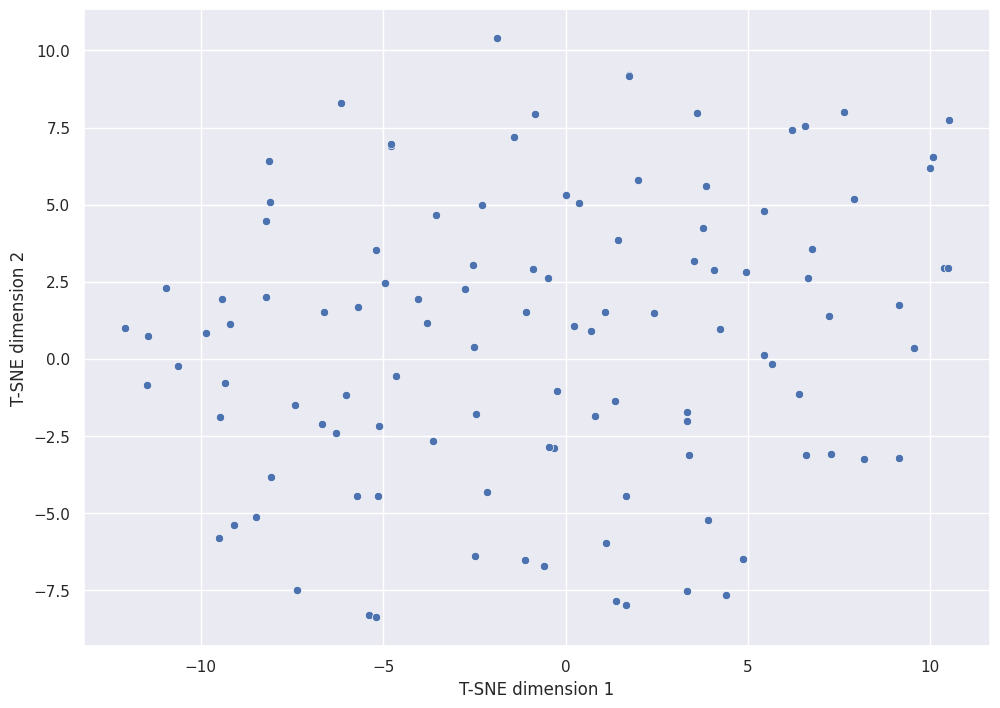

In [46]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
tsne = TSNE(perplexity=30)
X_embedded = tsne.fit_transform(candidate_embeddings)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], legend='full')
plt.xlabel(xlabel='T-SNE dimension 1')
plt.ylabel(ylabel='T-SNE dimension 2')
plt.show()